In [1]:
import paddle
paddle.__version__

'2.1.0'

In [3]:
data_path = "/home/gaojing/PTM/datasets/n-gram/t8.shakespeare.txt"
test_sentence = open(data_path, 'rb').read().decode(encoding='utf-8')
print ('Length of text: {} characters'.format(len(test_sentence)))

Length of text: 5458199 characters


In [4]:
##处理标点符号
from string import punctuation
process_dicts={i:'' for i in punctuation}
print(process_dicts)

punc_table = str.maketrans(process_dicts)
test_sentence = test_sentence.translate(punc_table)

{'!': '', '"': '', '#': '', '$': '', '%': '', '&': '', "'": '', '(': '', ')': '', '*': '', '+': '', ',': '', '-': '', '.': '', '/': '', ':': '', ';': '', '<': '', '=': '', '>': '', '?': '', '@': '', '[': '', '\\': '', ']': '', '^': '', '_': '', '`': '', '{': '', '|': '', '}': '', '~': ''}


In [8]:
##对句子进行截取2500个字
test_sentence_list = test_sentence.lower().split()

word_dict_count = {}
for word in test_sentence_list:
    word_dict_count[word] = word_dict_count.get(word, 0) + 1

word_list = []
soted_word_list = sorted(word_dict_count.items(), key=lambda x: x[1], reverse=True)
for key in soted_word_list:
    word_list.append(key[0])

word_list = word_list[:2500]
print(len(word_list))
print(word_list)

2500
['the', 'and', 'i', 'to', 'of', 'a', 'you', 'my', 'that', 'in', 'is', 'not', 'for', 'with', 'me', 'it', 'be', 'your', 'his', 'this', 'but', 'he', 'as', 'have', 'thou', 'so', 'him', 'will', 'what', 'by', 'thy', 'all', 'are', 'her', 'no', 'do', 'shall', 'if', 'we', 'thee', 'or', 'our', 'lord', 'on', 'king', 'good', 'now', 'sir', 'from', 'o', 'at', 'come', 'they', 'well', 'which', 'would', 'more', 'was', 'then', 'she', 'am', 'how', 'here', 'let', 'enter', 'their', 'love', 'when', 'them', 'ill', 'hath', 'than', 'may', 'an', 'man', 'there', 'one', 'go', 'upon', 'like', 'say', 'know', 'make', 'did', 'us', 'such', 'were', 'should', 'yet', 'must', 'why', 'see', 'had', 'tis', 'out', 'some', 'give', 'these', 'time', 'too', 'where', 'can', 'who', 'take', 'most', 'speak', 'first', 'mine', 'th', 'duke', 'up', 'tell', 'much', 'exeunt', 'think', 'never', 'heart', 'exit', 'nor', 'queen', 'doth', 'any', 'art', 'great', 'hear', 'lady', 'away', 'death', 'men', 'world', 'hand', 'father', 'before', 'l

In [6]:
# 设置参数
hidden_size = 1024               # Linear层 参数
embedding_dim = 256              # embedding 维度
batch_size = 256                 # batch size 大小
context_size = 2                 # 上下文长度
vocab_size = len(word_list) + 1  # 词表大小
epochs = 2                       # 迭代轮数

In [9]:
trigram = [[[test_sentence_list[i], test_sentence_list[i + 1]], test_sentence_list[i + 2]]
           for i in range(len(test_sentence_list) - 2)]

word_to_idx = {word: i+1 for i, word in enumerate(word_list)}
word_to_idx['<pad>'] = 0
idx_to_word = {word_to_idx[word]: word for word in word_to_idx}

# 看一下数据集
print(trigram[:3])

[[['this', 'is'], 'the'], [['is', 'the'], '100th'], [['the', '100th'], 'etext']]


In [10]:
test_sentence_list[0]

'this'

In [18]:
##重新paddle.io.Dataset数据
import numpy as np
class TrainDataset(paddle.io.Dataset):
    def __init__(self, tuple_data):
        self.tuple_data = tuple_data

    def __getitem__(self, idx):
        data = self.tuple_data[idx][0]
        label = self.tuple_data[idx][1]
        data = np.array(list(map(lambda word: word_to_idx.get(word, 0), data)))
        label = np.array(word_to_idx.get(label, 0))
        return data, label
    
    def __len__(self):
        return len(self.tuple_data)
    
train_dataset = TrainDataset(trigram)
train_loader = paddle.io.DataLoader(train_dataset, return_list=True, shuffle=True, 
                                    batch_size=batch_size, drop_last=True)

In [16]:
train_dataset.tuple_data
len(train_dataset)

900985

In [19]:
##模型搭建
import paddle.nn.functional as F

class NGramModel(paddle.nn.Layer):
    def __init__(self,vocab_size,embedding_dim,context_size):
        super(NGramModel,self).__init__()
        self.embedding = paddle.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.linear1 = paddle.nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear2 = paddle.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x = paddle.reshape(x, [-1, context_size * embedding_dim])
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
        
losses = []
def train(model):
    model.train()
    optim = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = F.cross_entropy(predicts, y_data)
            loss.backward()
            if batch_id % 500 == 0:
                losses.append(loss.numpy())
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy())) 
            optim.step()
            optim.clear_grad()
model = NGramModel(vocab_size, embedding_dim, context_size)
train(model)

epoch: 0, batch_id: 0, loss is: [7.8242297]
epoch: 0, batch_id: 500, loss is: [5.4249544]
epoch: 0, batch_id: 1000, loss is: [5.4307766]
epoch: 0, batch_id: 1500, loss is: [5.435846]
epoch: 0, batch_id: 2000, loss is: [5.158988]
epoch: 0, batch_id: 2500, loss is: [5.5496907]
epoch: 0, batch_id: 3000, loss is: [4.866588]
epoch: 0, batch_id: 3500, loss is: [5.2369456]
epoch: 1, batch_id: 0, loss is: [5.124364]
epoch: 1, batch_id: 500, loss is: [5.4210806]
epoch: 1, batch_id: 1000, loss is: [5.2266474]
epoch: 1, batch_id: 1500, loss is: [5.34957]
epoch: 1, batch_id: 2000, loss is: [5.0389977]
epoch: 1, batch_id: 2500, loss is: [5.3679647]
epoch: 1, batch_id: 3000, loss is: [5.7008166]
epoch: 1, batch_id: 3500, loss is: [5.156628]


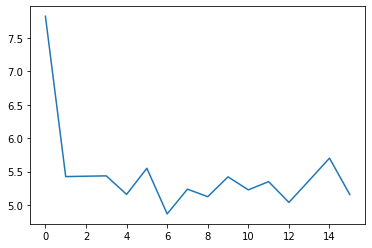

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(losses)